In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
# import sage
# from scipy.stats import rankdata
from scipy.stats import ttest_ind, t
import sys
from helper import *
from shapley_sampling import *
from os.path import join
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
# df = sage.datasets.credit()
# df.to_csv("Data/credit.csv")
df = pd.read_csv("Data/credit.csv", index_col=0)

# Property, other installment, housing, job, status of checking act, credit history, purpose, savings, employment since, marital status, old debtors
n = df.shape[0]
X_df = df.drop(["Good Customer"], axis=1)
y = df["Good Customer"]

categorical_columns = [
    'Checking Status', 'Credit History', 'Purpose', #'Credit Amount', # It's listed but has 923 unique values
    'Savings Account/Bonds', 'Employment Since', 'Personal Status',
    'Debtors/Guarantors', 'Property Type', 'Other Installment Plans',
    'Housing Ownership', 'Job', #'Telephone', 'Foreign Worker' # These are just binary
]
X_binarized = pd.get_dummies(X_df, columns=categorical_columns)

mapping_dict = {}
for i, col in enumerate(X_df.columns):
    bin_cols = []
    for j, bin_col in enumerate(X_binarized.columns):
        if bin_col.startswith(col):
            bin_cols.append(j)
    mapping_dict[i] = bin_cols

np.random.seed(1)
X_norm = (X_binarized-X_binarized.min())/(X_binarized.max()-X_binarized.min())
n_train = round(n*0.8)
train_idx = np.random.choice(n, n_train, replace=False)
X_train, y_train = X_norm.iloc[train_idx].to_numpy(), y.iloc[train_idx].to_numpy()
test_idx = np.setdiff1d(np.arange(n),train_idx)
X_test, y_test = X_norm.iloc[test_idx].to_numpy(), y.iloc[test_idx].to_numpy()
d = X_df.shape[1]

In [4]:
# def correct_cov(cov_mat,Kr = 10000):
#     u, s, vh = np.linalg.svd(cov_mat, full_matrices=True)
#     if np.max(s)/np.min(s) < Kr:
#         cov2 = cov_mat
#     else:
#         s_max = s[0]
#         min_acceptable = s_max/Kr
#         s2 = np.copy(s)
#         s2[s <= min_acceptable] = min_acceptable
#         cov2 = np.matmul(u, np.matmul(np.diag(s2), vh))
        
#     return (cov2+cov2.T)/2

# def logreg_gradient(y_pred, BETA):
#     '''
#     Computes the gradient of a logistic regression function fmodel with parameters BETA at xloc.
#     '''
#     d = BETA.shape[0]
#     return np.array(y_pred*(1-y_pred)*BETA).reshape((d, 1))


# def logreg_hessian(y_pred, BETA):
#     '''
#     Computes the hessian of a logistic regression function fmodel with parameters BETA at xloc.
#     '''
#     d = BETA.shape[0]
#     beta_2d = np.array(BETA).reshape((d, -1))
#     BBT = np.dot(beta_2d, beta_2d.T)
#     return y_pred*(1-y_pred)*(1-2*y_pred)*BBT

# def f_second_order_approx(y_pred, xnew, xloc, gradient, hessian):
#     '''
#     Second order approximation to model at xnew, a point around xloc. 
#     Relevant when assuming feature independence for both SHAP and kernelSHAP.
#     '''
#     if xnew.ndim==1:
#         xnew = xnew.reshape((1,xnew.shape[0]))
    
#     y_pred_pred = y_pred
#     n, d = xnew.shape
#     if n==1:
#         deltaX = np.array(xnew - xloc).reshape((d, -1))
#         second_order_approx = y_pred_pred + np.dot(deltaX.T, gradient) + 0.5*np.dot(np.dot(deltaX.T, hessian), deltaX) 
#         return second_order_approx.item()
#     else:
#         second_order_approx = np.zeros(n)
#         for i in range(n):
#             deltaX_i = np.array(xnew[i,:] - xloc).reshape((d, -1))
#             second_order_approx[i] = y_pred_pred + np.dot(deltaX_i.T, gradient) + 0.5*np.dot(np.dot(deltaX_i.T, hessian), deltaX_i)
#         return second_order_approx


# def compute_true_shap_cv_indep(xloc, gradient, hessian, feature_means, cov_mat, mapping_dict=None):
#     '''
#     Computes exact Shapley value of control variate in independent features case (second-order approximation).
#     '''
#     def compute_jth_shap_val(xloc, feature_means, cov_mat, j, gradient, hessian):
#         d = xloc.shape[1]
#         mean_j = feature_means[j]
#         xloc_j = xloc[0,j]
#         linear_term = gradient[j]*(xloc_j - mean_j)
#         mean_term = -0.5*(mean_j - xloc_j) * np.sum([(feature_means[k]-xloc[0,k])*hessian[j,k] for k in range(d)])
#         var_term = -0.5*np.sum([cov_mat[j,k]*hessian[j,k] for k in range(d)])
#         # old_var_term = -0.5*cov_mat[j,j]*hessian[j,j]
#         jth_shap_val = linear_term + mean_term + var_term
#         return jth_shap_val

#     d_total = xloc.shape[1]
#     shap_vals = np.array([compute_jth_shap_val(xloc, feature_means, cov_mat, j, gradient, hessian) for j in range(d_total)])

#     if mapping_dict is None:
#         return shap_vals
#     else:
#         # Account for multilevel features
#         shap_CV_true = []
#         d = len(mapping_dict)
#         for i in range(d):
#             relevant_cols = mapping_dict[i]
#             if len(relevant_cols)==1: # Not a column of a multilevel feature
#                 shap_CV_true.append(shap_vals[relevant_cols].item())
#             else:
#                 shap_CV_true.append(np.sum(shap_vals[relevant_cols]))

#         return np.array(shap_CV_true)
        


In [5]:
logreg = LogisticRegression().fit(X_train, y_train)
print("Class imbalance: {}".format(100*(max(np.mean(y_test), 1-np.mean(y_test)))))
print("Estimation accuracy: {}".format(np.mean((logreg.predict(X_test) > 0.5)==y_test)*100))

def fmodel(x):
    return logreg.predict_proba(x)[:,1]

Class imbalance: 72.0
Estimation accuracy: 74.0


In [9]:
# Compute mean and covariance of training data
feature_means = np.mean(X_train, axis=0)
cov_mat = correct_cov(np.cov(X_train, rowvar=False))

# Select point and compute its gradient and hessian
xloc = X_test[0:1]
BETA = logreg.coef_.reshape(-1)
y_pred = fmodel(xloc)
gradient = logreg_gradient(y_pred, BETA)
hessian = logreg_hessian(y_pred, BETA)

# Obtain true SHAP values and verify their feasibility
true_shap_vals = compute_shap_vals_quadratic(xloc, gradient, hessian, feature_means, cov_mat, mapping_dict=mapping_dict)

def model(input):
    return f_second_order_approx(y_pred,input,xloc,gradient,hessian)


## Shapley Sampling

### Algo 1a: Keep running for all features until convergence

In [9]:
%run shapley_sampling
np.random.seed(1)
K = 3
shap_vals, diffs_all_feats = shapley_sampling_basic(model, X_train, xloc, K, 
                                                    alpha=0.05, mapping_dict=mapping_dict, K_thru_rest=False)
print(diffs_all_feats.shape)


(20, 800)


### Algo 1b: Keep running on features that fail pairwise test

Enormously faster. e.g. K=5, >10x faster; K=3, ~8x faster
- This is in terms of the number of times computing $v_x(S \cup j) - v_x(S)$

In [11]:
# np.random.seed(1)
shap_vals2, diffs_all_feats2 = shapley_sampling_adaptive(model, X_train, xloc, K, 
                                        mapping_dict=mapping_dict, alpha=0.05, 
                                        n_perms_btwn_tests=50, n_samples_per_perm=2,
                                        K_thru_rest=False)
print(sum([len(diffs_all_feats2[j]) for j in range(len(diffs_all_feats2))]))
print(np.product(diffs_all_feats.shape))
print(np.argsort(np.abs(shap_vals2))[::-1])

2300
16000
[19  2  0  3  1  7 11  5  4  8  6 18 12 15 13 10 14 17  9 16]


Both methods get everything right, at least on the important features

In [12]:
print(np.argsort(np.abs(shap_vals))[::-1])
print(np.argsort(np.abs(shap_vals2))[::-1])
print(np.argsort(np.abs(true_shap_vals))[::-1])

[19  2  0  3  1  7 11  5  4  8  6 18 12 13 15 10 17  9 16 14]
[19  2  0  3  1  7 11  5  4  8  6 18 12 15 13 10 14 17  9 16]
[19  2  0  3  1  7 11  5  4  8 18  6 13 15 12 10 17  9 16 14]


## Simulation: Adaptive Procedure controls FWER!
Using alpha = 0.2 throughout. Expect ≤ 20% FWER.
#### K=3
Running 100x (takes 30 seconds)
- Only testing order of top-K: 13% FWER
- Also testing K vs K+1, K+2, ...: 11% FWER

Also ran with alpha = 0.05 (expect 5% FWER): Observed 4% FWER
- Again, slight benefit from also testing K vs K+1 through d. Used throughout.
#### K=5: only ~5% FWER
#### K=10: 12% FWER
- takes 1.5 mins

In [109]:
%run shapley_sampling
np.random.seed(2)
K = 10
true_order = np.argsort(np.abs(true_shap_vals))[::-1]
true_top_K = true_order[:K]
same_top_K = []
for i in range(100):
    shap_vals2, diffs_all_feats2 = shapley_sampling_adaptive(model, X_train, xloc, K, 
                                        mapping_dict=mapping_dict, alpha=0.2, 
                                        n_perms_btwn_tests=50, n_samples_per_perm=2,
                                        K_thru_rest=False)
    est_top_K = np.argsort(np.abs(shap_vals2))[::-1][:K]
    has_same_top_K = np.array_equal(true_top_K, est_top_K)
    same_top_K.append(has_same_top_K)
    if (i+1) % 10==0: print(i+1, np.mean(same_top_K))
np.mean(same_top_K)

10 0.7
20 0.8
30 0.8
40 0.85
50 0.86
60 0.8833333333333333
70 0.8857142857142857
80 0.8875
90 0.8777777777777778
100 0.88


0.88

### Show validity of null distribution
- Test statistic under null - that means are the same, so we can randomly permute - is indeed t-distributed

        - Not sure if this is OK to do, since variances aren't the same so under the null the distributions still aren't identical

In [81]:
%run shapley_sampling
np.random.seed(1)
n_subsets = 200
diffs_all_feats = compute_diffs_all_feats(model, X_train, xloc, n_subsets, mapping_dict=mapping_dict, n_samples_per_perm=2)
shap_ests = [np.mean(diffs_all_feats[j]) for j in range(d)]
order = get_ordering(shap_ests)

feat1 = diffs_all_feats[int(order[0])]
feat2 = diffs_all_feats[int(order[1])]
if np.mean(feat1)*np.mean(feat2) < 0:
    if isinstance(feat2, np.ndarray): feat2 = -feat2
    else: feat2 = [-feat2[j] for j in range(d)]
test_stat = ttest_ind(feat1, feat2, equal_var=False)[0]

both = np.concatenate((feat1, feat2))
test_stats_perm = []
for _ in range(1000):
    random_order = np.random.choice(n_subsets*2, size=n_subsets*2, replace=False)
    feat1_perm = both[random_order[:n_subsets]]
    feat2_perm = both[random_order[n_subsets:]]
    test_stats_perm.append(ttest_ind(feat1_perm, feat2_perm, equal_var=False)[0])

358.5337161164116


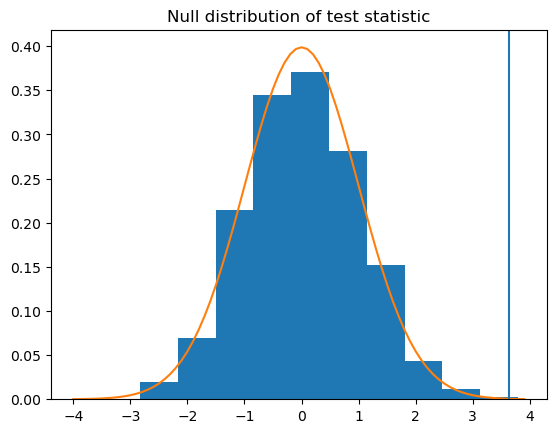

In [103]:
xs = np.arange(-4, 4, 0.1)

var1, var2 = np.var(feat1, ddof=1), np.var(feat2, ddof=1)
df = (n_subsets-1)*(var1 + var2)**2 / (var1**2 + var2**2)
print(df)
ys = t.pdf(xs, df=df)

plt.hist(test_stats_perm, density=True)
plt.plot(xs, ys)
plt.title("Null distribution of test statistic")
plt.axvline(test_stat)
plt.show()